# Model engineering 001: MultiLinearRegression

In this part of the project to predict the photovoltaic production of solar cells on a roof we are considering a simple regression model - MultiLinearRegression. 

We will treat this as a regression problem, not taking the temporal aspect, i.e. time series forcasting, into account. Data mining and missing value treatment of weather data from the DarkSky API and data from the photovoltaic system were covered in other notebooks:

- Data mining and EDA of weather data: https://kyso.io/heiko/predicting-solar-panel-output-eda-of-photovoltaic-data

- Data mining and EDA of photovoltaic data: https://kyso.io/heiko/predicting-solar-panel-output-eda-of-weather-data

- Missing value treatment: https://kyso.io/heiko/predicting-solar-panel-output-missing-value-treatment-of-weather-data

## Methodology

We will apply multilinear regression by following these steps:

1. Load the data into one dataframe

2. Select the features we will use for the prediction. We can look at the correlation matrix and remove redundant features that are correlated. Multicollinearity undermines the statistical significance of an independent variable. While it should not have a major impact on the model’s accuracy, it does affect the variance associated with the prediction, as well as, reducing the quality of the interpretation of the independent variables. In other words, the effect your data has on the model isn’t trustworthy. Your explanation of how the model takes the inputs to produce the output will not be reliable. (You can read more about this here: https://towardsdatascience.com/multicollinearity-why-is-it-a-problem-398b010b77ac). We will just drop (one of the) columns that are correlated. We could feature engineer another features that combines the correlated features, but at this point this will not be considered.

3. Consider missing values. This is still part of the feature selection process. We remove features that have lots of missing values that we could not interpolate.

4. Model selection. We will consider different techniques to determine which features to include in our model. We will use backward eliminiation and forward elimination.

## Import libraries

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score,mean_squared_error

import eli5
sns.set()
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Import dataset

Let's begin by importing the datasets for weather and photovoltaic data after missing value treatment. Check the links above for some insights on the data streams and treatment processes.

### DarkSky - Weather data

In [75]:
df_weather = pd.read_csv('../02.Prepared_data/DarkSky/data_after_missing_value_treatment.csv', parse_dates=['time', 'sunriseTime', 'sunsetTime'])
df_weather.head()

time  apparentTemperatureHigh  apparentTemperatureLow  cloudCover  \
0 2017-10-01                    15.92                    9.71         NaN   
1 2017-10-02                    17.15                   12.70        0.81   
2 2017-10-03                    16.14                    5.25        0.76   
3 2017-10-04                    15.47                    4.75         NaN   
4 2017-10-05                    19.81                    5.68         NaN   

   precipProbability precipType         sunriseTime          sunsetTime  \
0               0.76       rain 2017-10-01 07:29:00 2017-10-01 19:09:00   
1               0.81       rain 2017-10-02 07:30:00 2017-10-02 19:07:00   
2               0.99       rain 2017-10-03 07:32:00 2017-10-03 19:05:00   
3               0.62       rain 2017-10-04 07:33:00 2017-10-04 19:03:00   
4               0.99       rain 2017-10-05 07:34:00 2017-10-05 19:01:00   

   temperatureHigh  uvIndex  precipIntensityMax_cm  sun_uptime  
0            16.20      4.0               0.498348   11.666667  
1            17.43      3.0               0.548386   11.616667  
2            16.42      4.0              23.600410   11.550000  
3            15.75      0.0               0.403606   11.500000  
4            20.09      1.0               8.199120   11.450000

In [76]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time                     929 non-null    datetime64[ns]
 1   apparentTemperatureHigh  929 non-null    float64       
 2   apparentTemperatureLow   847 non-null    float64       
 3   cloudCover               744 non-null    float64       
 4   precipProbability        837 non-null    float64       
 5   precipType               839 non-null    object        
 6   sunriseTime              929 non-null    datetime64[ns]
 7   sunsetTime               929 non-null    datetime64[ns]
 8   temperatureHigh          929 non-null    float64       
 9   uvIndex                  895 non-null    float64       
 10  precipIntensityMax_cm    839 non-null    float64       
 11  sun_uptime               922 non-null    float64       
dtypes: datetime64[ns](3), float64(8), ob

With datetime values in the dataframe, it is always a good idea to check if pandas has correctly parsed the dates. It seems here that no datetime was incorrectly stored as an object datatype in the dataframe, so all good.

### Solar output data

In [77]:
df_prod = pd.read_csv('../02.Prepared_data/photovoltaic/integrated_daily.csv', parse_dates=['day'])
df_prod.head()

day     energy season
0 2017-10-12   2.907333   fall
1 2017-10-13  29.549000   fall
2 2017-10-14  28.653833   fall
3 2017-10-15  28.409750   fall
4 2017-10-16  27.371084   fall

In [78]:
df_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   day     624 non-null    datetime64[ns]
 1   energy  624 non-null    float64       
 2   season  624 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 14.8+ KB


## Merge datasets

Let's combine all the dataframes.

In [79]:
df = pd.merge(df_prod, df_weather, left_on='day', right_on='time')
df = df.set_index('day')

In [80]:
# what missing values there are
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing,
                                'absolute_missing': df.isnull().sum()})
missing_value_df

column_name  percent_missing  \
energy                                    energy         0.000000   
season                                    season         0.000000   
time                                        time         0.000000   
apparentTemperatureHigh  apparentTemperatureHigh         0.000000   
apparentTemperatureLow    apparentTemperatureLow        13.141026   
cloudCover                            cloudCover        29.006410   
precipProbability              precipProbability        14.743590   
precipType                            precipType        14.423077   
sunriseTime                          sunriseTime         0.000000   
sunsetTime                            sunsetTime         0.000000   
temperatureHigh                  temperatureHigh         0.000000   
uvIndex                                  uvIndex         5.448718   
precipIntensityMax_cm      precipIntensityMax_cm        14.423077   
sun_uptime                            sun_uptime         1.121795   

                         absolute_missing  
energy                                  0  
season                                  0  
time                                    0  
apparentTemperatureHigh                 0  
apparentTemperatureLow                 82  
cloudCover                            181  
precipProbability                      92  
precipType                             90  
sunriseTime                             0  
sunsetTime                              0  
temperatureHigh                         0  
uvIndex                                34  
precipIntensityMax_cm                  90  
sun_uptime                              7

In [81]:
df_prod.shape, df.shape

((624, 3), (624, 14))

Looks good, we have the two datasets merged. Let us now consider which features we are going to use for our prediction.

## Feature selection


This step is non-trivial, but we already know from the correlation matrix that there are some highly correlated values among the temperature columns.

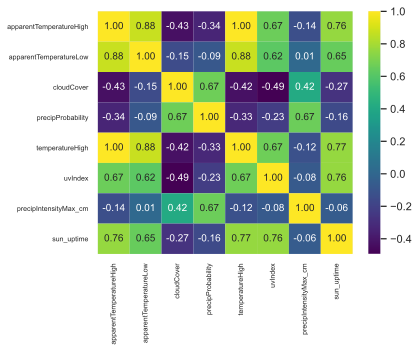

In [82]:

# %matplotlib inline

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_weather.corr(), ax=ax, annot=True, cmap='viridis', fmt="0.2f");
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()


Since the `apparentTemperatureHigh` column has no missing values, we will use this column as the temperature information and drop the others. Also we can drop `time`, `sunriseTime`, and `sunSetTime` since they are not relevant further (we know the difference between sunset and rise from the `sun_uptime` column).

In [83]:
df_cleaned = df.drop(columns=['time', 'apparentTemperatureLow', 'temperatureHigh', 'sunriseTime', 'sunsetTime'])
df_cleaned.head()

energy season  apparentTemperatureHigh  cloudCover  \
day                                                                 
2017-10-12   2.907333   fall                    18.74        0.68   
2017-10-13  29.549000   fall                    21.26         NaN   
2017-10-14  28.653833   fall                    21.30         NaN   
2017-10-15  28.409750   fall                    25.41         NaN   
2017-10-16  27.371084   fall                    25.55         NaN   

            precipProbability precipType  uvIndex  precipIntensityMax_cm  \
day                                                                        
2017-10-12               0.00       none      3.0               0.000000   
2017-10-13               0.70       rain      0.0               0.330708   
2017-10-14               0.63       rain      0.0               0.305562   
2017-10-15               0.62       rain      0.0               0.406146   
2017-10-16               0.00       none      0.0               0.000000   

            sun_uptime  
day                     
2017-10-12   11.050000  
2017-10-13   10.983333  
2017-10-14   10.933333  
2017-10-15   10.866667  
2017-10-16   10.816667

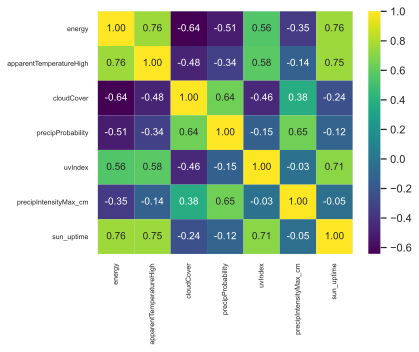

In [84]:

# %matplotlib inline

fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(df_cleaned.corr(), ax=ax, annot=True, cmap='viridis', fmt="0.2f");
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.show()



We can see now that the target column, `energy` is highly positively correlated with the temperature and uptime and moderately negatively correlated with the `cloudCover` column which is not very surprising and agrees with our intuition - when the temperature and sun hours are high, the energy produced during one day will be high and if there are a lot of clouds, there will be less energy produced.

## Missing values

We already know that there are a bunch of missing values in 2018 and they are clumped, so there is nothing to be done about it. We will drop these columns. 

We will also drop the `cloudCover` column because it has the most missing values and is correlated with the probability for precipitation for which we have more datapoints. That way we do not loose 30% of the data, but only around 15%.

In [85]:
df_cleaned = df_cleaned.drop(columns=['cloudCover'])
size_before = df_cleaned.shape[0]
df_cleaned = df_cleaned.dropna()
size_after = df_cleaned.dropna().shape[0]
print(f"Dropped {size_before-size_after} ({100 * (size_before-size_after)/size_before:.2f}%) entries because of missing values. New size is {size_after} entries.")

Dropped 93 (14.90%) entries because of missing values. New size is 531 entries.


### Export this dataset

Exporting this dataset makes sense because we can save the analysis steps for other models that we consider and make sure that we use the same baseline for the other models.

In [86]:
df_cleaned.to_csv('../02.Prepared_data/dataset.Model_eng.001.csv', index=False)

## Select features

In [87]:
# X = df_cleaned.iloc[:, 1:].values
X = df_cleaned.iloc[:, 1:]
X = X.reset_index(drop=True)
# y = df_cleaned.iloc[:, 0].values
y = df_cleaned.iloc[:, 0]
y = y.reset_index(drop=True)

## Pipeline

Let's make our pipeline for the preprocessing here. That allows later some easier changes.

In [88]:
X.head()

season  apparentTemperatureHigh  precipProbability precipType  uvIndex  \
0   fall                    18.74               0.00       none      3.0   
1   fall                    21.26               0.70       rain      0.0   
2   fall                    21.30               0.63       rain      0.0   
3   fall                    25.41               0.62       rain      0.0   
4   fall                    25.55               0.00       none      0.0   

   precipIntensityMax_cm  sun_uptime  
0               0.000000   11.050000  
1               0.330708   10.983333  
2               0.305562   10.933333  
3               0.406146   10.866667  
4               0.000000   10.816667

### Numeric features: StandardScaler

Standardize features by removing the mean and scaling to unit variance

In [89]:
numeric_features = ['apparentTemperatureHigh', 'precipProbability', 'uvIndex', 'precipIntensityMax_cm', 'sun_uptime']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

### Categorical features: OneHotEncoder

This preprocessing step will encode the `season` and `precipType` column values into a vector of length 3. For example, winter will be encoded as [1,0,0], summer as [0,1,0], and so on for the other seasons.

In [90]:
categorical_features = ['season', 'precipType']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

### Model

In [91]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Fit

Let's fit the model to the training data

In [92]:
clf.fit(X_train, y_train);

### Score (Full model, M0)


In [93]:
def adjR2(R2, n, p):
    """
    Returns the adjusted R2 score using R2 score, n, and p.
    n: size of dataset
    p: number of predictors
    """
    return 1-(1-R2)*(n-1)/(n-p-1)

In [94]:
y_test_predict = clf.predict(X_test)
y_train_predict = clf.predict(X_train)

M0_R2 = r2_score(y_test, y_test_predict)
M0_R2_train = r2_score(y_train, y_train_predict)

n = X_train.shape[0]
p = 1
M0_adj_R2 = adjR2(M0_R2, n, p)
M0_adj_R2_train = adjR2(M0_R2_train, n, p)

print(f"Train dataset -- R2 score: {M0_R2_train:.2f}, adjusted R2: {M0_adj_R2_train:.2f}.")
print(f"Test dataset -- R2 score: {M0_R2:.2f}, adjusted R2: {M0_adj_R2:.2f}.")

print(f"r2_score: {r2_score(y_test, y_test_predict)}")
print(f"MSE: {mean_squared_error(y_test, y_test_predict)}")

Train dataset -- R2 score: 0.77, adjusted R2: 0.77.
Test dataset -- R2 score: 0.72, adjusted R2: 0.72.
r2_score: 0.7190894719908503
MSE: 54.70055724462856


### Feature importance

Let's assess the feature importances that the model has found.

Feature: 0, Score: 5.94872
Feature: 1, Score: -3.94178
Feature: 2, Score: 0.90374
Feature: 3, Score: -1.73715
Feature: 4, Score: 5.18637
Feature: 5, Score: -2.65664
Feature: 6, Score: 3.86144
Feature: 7, Score: -3.12073
Feature: 8, Score: 1.91593
Feature: 9, Score: -0.37593
Feature: 10, Score: -1.28071
Feature: 11, Score: 1.65664


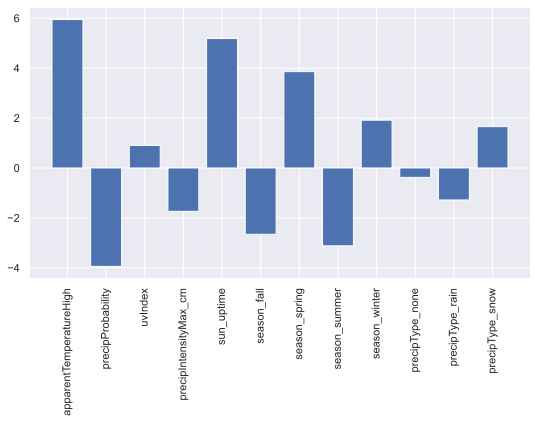

In [95]:
# get importance
importance = clf['classifier'].coef_

# get feature names
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)



# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot feature importance
fig, ax = plt.subplots(figsize=(9,5))
plt.bar([x for x in range(len(importance))], importance, align='center')
plt.xticks(np.arange(0, len(importance)), numeric_features_list, rotation=90)
plt.show()

In [96]:
eli5.explain_weights(clf.named_steps['classifier'], top=20, feature_names=numeric_features_list)

Explanation(estimator='LinearRegression()', description="\nFeatures with largest coefficients.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=20.131692932868418, std=None, value=None), FeatureWeight(feature='apparentTemperatureHigh', weight=5.9487222829151865, std=None, value=None), FeatureWeight(feature='sun_uptime', weight=5.186369031174467, std=None, value=None), FeatureWeight(feature='season_spring', weight=3.861441494504958, std=None, value=None), FeatureWeight(feature='season_winter', weight=1.9159285604183014, std=None, value=None), FeatureWeight(feature='precipType_snow', weight=1.6566386622025684, std=None, value=None), FeatureWeight(feature='uvIndex', weight=0.9037350658615191, std=None, value=None)], neg=[FeatureWeight(feature='precipProbability', weight=-3.9417814345826967, std=None, value=None), FeatureWeight(feature='season_summer', weight=-3.1207275626659086, std=None, value=None), FeatureWeight(feature='season_fall', weight=-2.656642492257353, std=None, value=None), FeatureWeight(feature='precipIntensityMax_cm', weight=-1.737147654237253, std=None, value=None), FeatureWeight(feature='precipType_rain', weight=-1.2807098763037015, std=None, value=None), FeatureWeight(feature='precipType_none', weight=-0.3759287858988674, std=None, value=None)], pos_remaining=0, neg_remaining=0), proba=None, score=None, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

We see that the temperature and sun uptime have high linear coefficients. For model selection, we will now use forward stepwise selection.

## Backward elimination

Let's use the p-values to select parameters to stay in the model. For that we will use backward elimination.

1. Select significance level to stay in the model. We use $\alpha=0.05$.

2. Fit full model with all predictors

3. Consider predictor with highest p-value. If that p-value $> \alpha$, go to step 4, otherwise end.

4. Remove the predictor with the largest p-value.

5. Fit model without this variable, back to step 3.

### Get the full model 

In [97]:
pipe_preprocess = clf.named_steps['preprocessor']
# transform the feature data using the training data
X_train_transformed = pipe_preprocess.fit_transform(X_train)
X_test_transformed = pipe_preprocess.fit_transform(X_test)
# add back the column headers
# get feature names
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=numeric_features_list, dtype=np.float)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=numeric_features_list, dtype=np.float)
X_train_transformed_full = X_train_transformed.copy()
X_train_transformed.head()

apparentTemperatureHigh  precipProbability   uvIndex  \
0                 0.953787          -0.860363 -0.208535   
1                 0.874835          -1.013745  0.291007   
2                 1.107047          -1.090436  0.291007   
3                 1.404278          -1.167127 -1.207619   
4                 0.490525           1.133605  1.789633   

   precipIntensityMax_cm  sun_uptime  season_fall  season_spring  \
0              -0.471901   -0.132779          1.0            0.0   
1              -0.558235    0.315595          1.0            0.0   
2              -0.577376   -0.289030          1.0            0.0   
3              -0.580430    0.974569          0.0            1.0   
4              -0.270419    1.232724          0.0            1.0   

   season_summer  season_winter  precipType_none  precipType_rain  \
0            0.0            0.0              0.0              1.0   
1            0.0            0.0              0.0              1.0   
2            0.0            0.0              0.0              1.0   
3            0.0            0.0              1.0              0.0   
4            0.0            0.0              0.0              1.0   

   precipType_snow  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

This is the full model, let's now implement the backward elimination procedure.

In [98]:
import statsmodels.api as sm

    
alpha = 0.05 # significance level
pvals_max = 10

while pvals_max >= alpha:
    #Adding constant column of ones, mandatory for sm.OLS model
    X_train_1 = sm.add_constant(X_train_transformed)
    #Fitting sm.OLS model
    model = sm.OLS(y_train.values, X_train_1).fit()
    pvals = model.pvalues.sort_values()
    # largest pval is at the last position of the series
    pvals_max = pvals.iloc[-1]
    col_to_drop = pvals.index[-1]
    X_train_transformed = X_train_transformed.drop(columns=[col_to_drop])

pvals

const                      7.208224e-68
apparentTemperatureHigh    1.173004e-19
sun_uptime                 1.806670e-17
precipProbability          5.241167e-14
precipType_snow            7.337528e-10
precipType_rain            2.881559e-09
season_spring              6.159340e-09
season_winter              3.840635e-05
precipIntensityMax_cm      2.543960e-04
precipType_none            2.696352e-04
dtype: float64

In [99]:
features = pvals.index.tolist()
features = [f for f in features if f is not 'const']
features

['apparentTemperatureHigh',
 'sun_uptime',
 'precipProbability',
 'precipType_snow',
 'precipType_rain',
 'season_spring',
 'season_winter',
 'precipIntensityMax_cm',
 'precipType_none']

Using backward elimination we found the features to be used in the model to be:

`apparentTemperatureHigh`, <br>
`sun_uptime`,<br>
`precipProbability`,<br>
`precipType_snow`,<br>
`precipType_rain`,<br>
`season_spring`,<br>
`season_winter`,<br>
`precipIntensityMax_cm`,<br>
`precipType_none`

Let's run the regression model with these features.

In [100]:
# drop the features we did not want to consider
cols_to_drop = X_train_transformed_full.columns
cols_to_drop = [c for c in cols_to_drop if c not in features]
X_train_transformed_full = X_train_transformed_full.drop(columns=cols_to_drop)
X_test_transformed = X_test_transformed.drop(columns=cols_to_drop)

In [101]:
# run model
pipe_lm = clf.named_steps['classifier']
pipe_lm.fit(X_train_transformed_full, y_train)

y_test_predict = pipe_lm.predict(X_test_transformed)
y_train_predict = pipe_lm.predict(X_train_transformed_full)

M1_R2 = r2_score(y_test, y_test_predict)
M1_R2_train = r2_score(y_train, y_train_predict)

n = X_train.shape[0]
p = 1
M1_adj_R2 = adjR2(M1_R2, n, p)
M1_adj_R2_train = adjR2(M1_R2_train, n, p)
print("Backward eliminated model:")
print(f"Train dataset -- R2 score: {M1_R2_train:.2f}, adjusted R2: {M1_adj_R2_train:.2f}.")
print(f"Test dataset -- R2 score: {M1_R2:.2f}, adjusted R2: {M1_adj_R2:.2f}.")

Backward eliminated model:
Train dataset -- R2 score: 0.77, adjusted R2: 0.76.
Test dataset -- R2 score: 0.69, adjusted R2: 0.69.


In [102]:
print("Full model:")
print(f"Train dataset -- R2 score: {M0_R2_train:.2f}, adjusted R2: {M0_adj_R2_train:.2f}.")
print(f"Test dataset -- R2 score: {M0_R2:.2f}, adjusted R2: {M0_adj_R2:.2f}.")

Full model:
Train dataset -- R2 score: 0.77, adjusted R2: 0.77.
Test dataset -- R2 score: 0.72, adjusted R2: 0.72.


We see that from the R2 score, our eliminated model performed worse compared to the full model.

## Forward stepwise selection

The approach for forward stepwise selection is the following:

1. Start with the null model, $M_0$ that contains no predictors.


2. For $k = 1, ... p-1$:

    a. Consider all $p-k$ models that augment the predictors in $M_k$ with one additional predictor
    
    b. Choose the best among these $p-k$ models, call it $M_{k+1}$. Best is defined as having the smallest RSS or highest R$^2$
    
    
3. Select a single best model from among $M_0, ..., M_p$ using crossvalidated prediction error, $C_p$ (AIC), BIC, or adjusted R$^2$.

In [103]:
adjR2s = []
CPs = []
BICs = []
features_good = []

### Null model 

In [104]:
#Fitting sm.OLS model
X_train_tmp = sm.add_constant(X_train)['const']
model = sm.OLS(y_train.values, X_train_tmp).fit()

adjR2s.append(model.rsquared_adj)
CPs.append(model.aic)
BICs.append(model.bic)

### Forward stepwise selection


To implement the forward stepwise selection, we first preprocess all the features.

In [105]:
pipe_preprocess = clf.named_steps['preprocessor']
# transform the feature data using the training data
X_train_tf = pipe_preprocess.fit_transform(X_train)
X_test_tf = pipe_preprocess.fit_transform(X_test)
# add back the column headers
# get feature names
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)
X_train_tf = pd.DataFrame(X_train_tf, columns=numeric_features_list, dtype=np.float)
X_test_tf = pd.DataFrame(X_test_tf, columns=numeric_features_list, dtype=np.float)

# features that can be added to the model
features = X_train_tf.columns

while len(features) > 0:
    r2 = pd.Series() # rsquared values in this iteration
    for f in features:
        features_select = features_good.copy()
        features_select.append(f)
        # features to select from the dataframe
        X_tmp = sm.add_constant(X_train_tf[features_select])
        model = sm.OLS(y_train.values, X_tmp).fit()
        # check if that r2 is higher
        r2[f] = model.rsquared

    # feature with maximum r2 gets added to the selected feature list
    f = r2.sort_values().index[-1]
    features_good.append(f)
    # remove the feature from the features for the next iteration
    features = features.drop(f)
    
    # compute metrics from these models
    X_tmp = sm.add_constant(X_train_tf[features_good])
    model = sm.OLS(y_train.values, X_tmp).fit()
    adjR2s.append(model.rsquared_adj)
    CPs.append(model.aic)
    BICs.append(model.bic)
    
adjR2s = np.asarray(adjR2s)
CPs = np.asarray(CPs)
BICs = np.asarray(BICs)


/Users/hkromer/anaconda3/envs/cryptominer/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


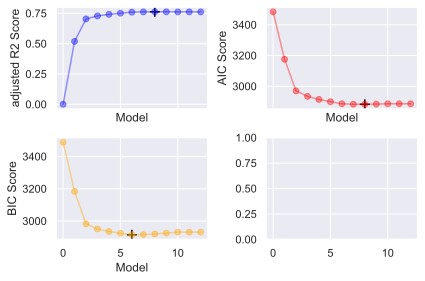

In [115]:
fig, axs = plt.subplots(2, 2, sharex=True)

axs[0][0].plot(np.arange(len(adjR2s)), adjR2s, marker='o', color='blue', alpha=0.4)
axs[0][0].set_xlabel('Model')
axs[0][0].set_ylabel('adjusted R2 Score')
adjR2_best = np.argmax(adjR2s)
axs[0][0].scatter([adjR2_best], [np.max(adjR2s)], marker='+', s=100, color='black')

axs[0][1].plot(np.arange(len(CPs)), CPs, marker='o', color='red', alpha=0.4)
axs[0][1].set_xlabel('Model')
axs[0][1].set_ylabel('AIC Score')
CPs_best = np.argmin(CPs)
axs[0][1].scatter([CPs_best], [np.min(CPs)], marker='+', s=100, color='black')


axs[1][0].plot(np.arange(len(BICs)), BICs, marker='o', color='orange', alpha=0.4)
axs[1][0].set_xlabel('Model')
axs[1][0].set_ylabel('BIC Score')
BIC_best = np.argmin(BICs)
axs[1][0].scatter([BIC_best], [np.min(BICs)], marker='+', s=100, color='black')

plt.tight_layout()
plt.savefig('model_selection.png', dpi=900)
plt.show()

In [107]:
adjR2_best, CPs_best, BIC_best

(8, 8, 6)

On the training data set, the model with 9 or 7 features (index in the list starts at 0) performs best, let's see how that performs on the test dataset.

In [108]:
adjR2s_test = []
CPs_test = []
BICs_test = []

In [109]:
M_adjR2 = features_good[0:adjR2_best+1] # best model from adjusted R2
X_design = sm.add_constant(X_test_tf[M_adjR2])
model = sm.OLS(y_test.values, X_design).fit()
adjR2s_test.append(model.rsquared_adj)
CPs_test.append(model.aic)
BICs_test.append(model.bic)
    


In [110]:
M_CP = features_good[0:CPs_best+1] # best model from CP
X_design = sm.add_constant(X_test_tf[M_CP])
model = sm.OLS(y_test.values, X_design).fit()
adjR2s_test.append(model.rsquared_adj)
CPs_test.append(model.aic)
BICs_test.append(model.bic)
    

In [111]:
M_BIC = features_good[0:BIC_best+1] # best model from BIC
X_design = sm.add_constant(X_test_tf[M_BIC])
model = sm.OLS(y_test.values, X_design).fit()
adjR2s_test.append(model.rsquared_adj)
CPs_test.append(model.aic)
BICs_test.append(model.bic)
    

In [112]:
# full model
X_design = sm.add_constant(X_test_tf)
model = sm.OLS(y_test.values, X_design).fit()
adjR2s_test.append(model.rsquared_adj)
CPs_test.append(model.aic)
BICs_test.append(model.bic)
    
adjR2s_test = np.asarray(adjR2s_test)
CPs_test = np.asarray(CPs_test)
BICs_test = np.asarray(BICs_test)

In [113]:
print("Performance on test set: Best model adjusted r2, CP, BIC, full model")
print("Adjusted r2:")
print(adjR2s_test)
print("CP:")
print(CPs_test)
print("BIC")
print(BICs_test)

Performance on test set: Best model adjusted r2, CP, BIC, full model
Adjusted r2:
[0.72016406 0.72016406 0.71423215 0.74028067]
CP:
[741.94934462 741.94934462 742.37755474 734.85811558]
BIC
[768.67763297 768.67763297 763.76018541 764.25923276]


We see that only in terms of BIC the model with the selected features performed better than the full model. This is likely attributed to the fact that we did not consider removing the full categorical set of features but selected each one hot encoded feature separately, which is not smart to do. We could re-run this selection process again, keeping track of categorical features. For now, we can leave it like that and use the full model to compare different regression models and their performance.

# Conclusion

We applied MultiLinear regression to the dataset, predicting the solar panel output values for different weather conditions.
For the full model that we selected, we found a MSE (root mean squared error) of 54.7 and an r2_score of 0.72.

Model selection did not significantly improve performance on the test set.
